In [1]:
# Import library
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [2]:
# Download required NLTK resources (you can skip this if already installed)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Read dataset  
data = pd.read_csv('../Dataset/ShopperSentiments.csv',encoding='ISO-8859-1') 
data.head() 

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4


# Data Cleaning

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278100 entries, 0 to 278099
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_id     278099 non-null  float64
 1   store_location  278100 non-null  object 
 2   latitude        278100 non-null  float64
 3   longitude       278100 non-null  float64
 4   date            278100 non-null  int64  
 5   month           278100 non-null  int64  
 6   year            278100 non-null  object 
 7   title           278088 non-null  object 
 8   review          247597 non-null  object 
 9   review-label    278100 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 21.2+ MB


In [5]:
data.isna().sum()

reviewer_id           1
store_location        0
latitude              0
longitude             0
date                  0
month                 0
year                  0
title                12
review            30503
review-label          0
dtype: int64

In [6]:
# Assuming your DataFrame is named 'df'
null_rows = data[data.isnull().any(axis=1)]
null_rows.head()

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
121,121.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Awesome t-shirt love it vintage ï¿½ï¿½ï¿½ï¿½,NaN,5
128,128.0,US,37.090240,-95.712891,2023,6,2018 00:00:00,Nice tee quick delivery -,NaN,5
130,130.0,US,37.090240,-95.712891,2023,6,2023 00:00:00,Big selections lots to choose from,NaN,5
142,142.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Great company,NaN,5
146,146.0,CA,56.130366,-106.346771,2023,6,2024 00:00:00,Great as always!,NaN,5


In [7]:
data.duplicated().sum()

0

# CLeaning data

In [8]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247587 entries, 0 to 278098
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_id     247587 non-null  float64
 1   store_location  247587 non-null  object 
 2   latitude        247587 non-null  float64
 3   longitude       247587 non-null  float64
 4   date            247587 non-null  int64  
 5   month           247587 non-null  int64  
 6   year            247587 non-null  object 
 7   title           247587 non-null  object 
 8   review          247587 non-null  object 
 9   review-label    247587 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 20.8+ MB


In [9]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [10]:
def clean_and_tokenize(text):
    # Remove non-alphabetical characters (remove numbers, punctuation, etc.)
    text_cleaned = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Tokenize the text into words
    tokens = word_tokenize(text_cleaned)

    # Remove stopwords
    tokens_no_stopwords = [word for word in tokens if word not in stop_words]

    # Lemmatize words (optional but often useful)
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]

    # Return the tokens as a string (for TF-IDF processing)
    return " ".join(tokens_lemmatized)  # Join tokens into a single string

In [11]:
# Combine 'title' and 'review' into one text field
data['combined_text'] = data['title'] + " " + data['review']

# Apply the clean_and_tokenize function to 'combined_text'
data['cleaned_tokens'] = data['combined_text'].apply(clean_and_tokenize)

# Show the DataFrame with the new 'cleaned_tokens' column
print(data[['combined_text', 'cleaned_tokens']].head())


                                       combined_text  \
0  Great help with lost order I had an order that...   
1  I ordered the wrong size tee and hadï¿½ï¿½ï¿½ ...   
2  These guys offer the best customerï¿½ï¿½ï¿½ Th...   
3  Good Stuff Looked for an obscure phrase on a s...   
4  My order arrived in a good timelyï¿½ï¿½ï¿½ My ...   

                                      cleaned_tokens  
0  great help lost order order lost transit calle...  
1  ordered wrong size tee ordered wrong size tee ...  
2  guy offer best customer guy offer best custome...  
3  good stuff looked obscure phrase shirt teepubl...  
4  order arrived good timely order arrived good t...  


In [12]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')  # Adjust max_features if needed

# Apply TF-IDF on the cleaned text data
text_features = tfidf.fit_transform(data['cleaned_tokens']).toarray()

# Check the shape of the text feature matrix
print("TF-IDF Shape:", text_features.shape)

TF-IDF Shape: (247587, 2000)


In [13]:
# Select relevant numerical features
numerical_features = data[['review-label']]  # Add more features like 'latitude', 'longitude', etc.

# Scale the numerical features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# Combine TF-IDF and numerical features
combined_features = np.hstack((text_features, numerical_features_scaled))

# Check the shape of the combined feature matrix
print("Combined Features Shape:", combined_features.shape)


Combined Features Shape: (247587, 2001)


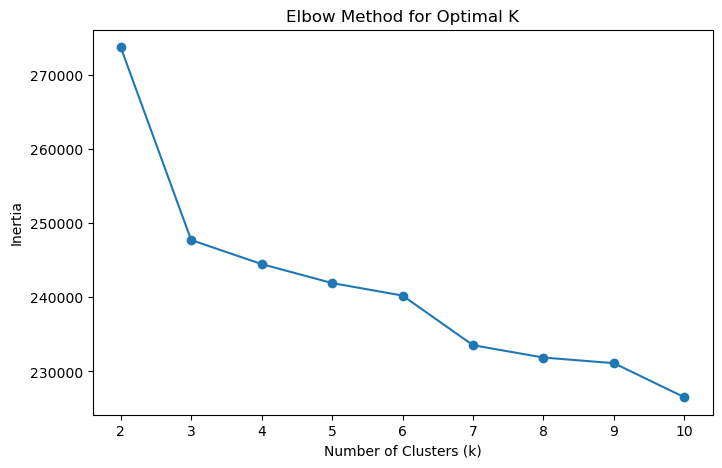

In [14]:
# Define range of k
k_range = range(2, 11)
inertia_values = []

# Fit KMeans for each k and record inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [15]:
# Perform KMeans with chosen k
optimal_k = 3  # Replace with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(combined_features)

# Add cluster labels to the original dataset
data['cluster'] = cluster_labels


In [16]:
data['cluster'].value_counts()

cluster
2    181426
0     38686
1     27475
Name: count, dtype: int64

In [17]:
silhouette_avg = silhouette_score(combined_features, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')


Silhouette Score: 0.245


cluster
2    181426
0     38686
1     27475
Name: count, dtype: int64


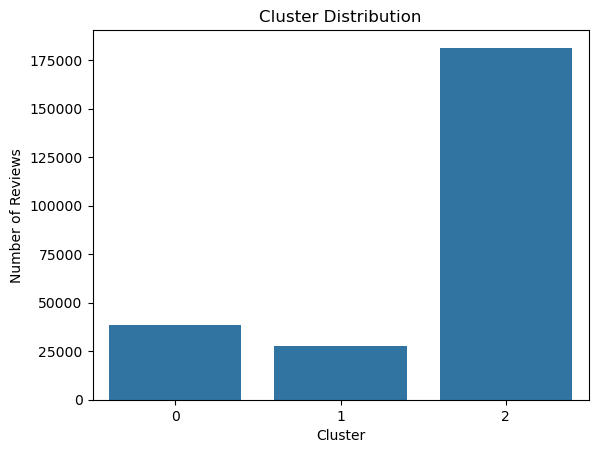


Cluster 0:
4     My order arrived in a good timelyï¿½ï¿½ï¿½ My ...
6     Recent review I have messaged sellers and get ...
10    I love the shirts I love the shirts. I wanted ...
13    Customer service was first rate but theï¿½ï¿½ï...
15    I loved the product but they run small ! I lov...
Name: combined_text, dtype: object

Cluster 1:
23     I did not receive my purchase and whenï¿½ï¿½ï¿...
47     The tee that I originally ordered wasï¿½ï¿½ï¿½...
60     Subpar communication after a horribleï¿½ï¿½ï¿½...
73     Arrogance or Ignorance? - You're Opting in for...
125    2 out of the 4 T Shirts I received wereï¿½ï¿½ï...
Name: combined_text, dtype: object

Cluster 2:
0    Great help with lost order I had an order that...
1    I ordered the wrong size tee and hadï¿½ï¿½ï¿½ ...
2    These guys offer the best customerï¿½ï¿½ï¿½ Th...
3    Good Stuff Looked for an obscure phrase on a s...
5    Always top notch Always top notch customer ser...
Name: combined_text, dtype: object


In [19]:
# Check the distribution of data in each cluster
print(data['cluster'].value_counts())

# Visualize cluster sizes
sns.countplot(x='cluster', data=data)
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.show()

# Analyze text within each cluster
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    print(data[data['cluster'] == cluster]['combined_text'].head(5))  # Display top 5 reviews in each cluster
